Nadia Morgen - Project 3, Notebook 3: Modeling

# Step 3: Modeling

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_classification

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [10]:
!pwd

/Users/nadiamorgen/General_Assembly/week_1/dsir-82/projects/project-3


In [13]:
df = pd.read_csv('data_finally_clean.csv')
df2 = pd.read_csv('df2_clean.csv')

In [ ]:
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [ ]:
df.head(3)

In [ ]:
df2.head(1)

In [ ]:
# This column keeps disappearing on me
df2 = pd.get_dummies(df2, columns=['subreddit'])

In [ ]:
df2.drop(columns='subreddit_universalstudios', inplace=True)
df2.rename({'subreddit_disneyparks':'disney_y'}, axis=1, inplace=True)

In [ ]:
df2.head(1)

# Null Model

In [ ]:
# Null Model
df['disney_y'].value_counts(normalize=True)

This means that about half of the predictions will be Disney and half will be Universal.

In [ ]:
df.columns

In [ ]:
df2.columns

# Logistic Regression

Quantitative Models of Selftext Word Count and Title Word Count vs Subreddit
* Note that the title_word_count field is cleaned, tokenized, and lemmatized

In [ ]:
lgr = LogisticRegression()

In [ ]:
X_lgr = df[['title_word_count']]
y_lgr = df['disney_y']

In [ ]:
X_train_lgr, X_test_lgr, y_train_lgr, y_test_lgr = train_test_split(X_lgr, y_lgr, test_size=.33, random_state=42, stratify = y)

In [ ]:
lgr.fit(X_lgr, y_lgr)

In [ ]:
# Make predictions
y_pred_lgr = lgr.predict(X_lgr)

# Create residuals
resids_lgr = y_lgr - y_pred_lgr

In [ ]:
lgr.score(X_train_lgr, y_train_lgr)

In [ ]:
lgr.score(X_test_lgr, y_test_lgr)

Well, there's no overfit, since the two logistic regression scores are nearly equal.  However - and not surprisingly - the model is also very close to the Null model.  It's really no improvement.  Title word count does not help predict whether a subreddit title is from disneyparks or universalstudios.

In [ ]:
df2 = sm.add_constant(df2, has_constant='add')

In [ ]:
# Verify that constant was added

In [ ]:
df2.head(1)

This time I'll try selftext word count, using the smaller (df2) dataset, since it looked like there was a significant difference in length in the plots shown earlier.

In [ ]:
Xst = df2[['const', 'selftext_word_count']]
yst = df2['disney_y']
results = sm.Logit(yst, Xst).fit()

print(results.summary())

Although the p-value is fantastic and the R2 and adjusted R2 are identical, the R-squareds are lousy and indicate no correlation between selftext word count and subreddit.

# Random Forest Classifier

Using a random forest classifier to analyze the text of statuses is another way to approach reddit classification.  The idea is to see whether random forest classification can accurately distinguish between the disneyparks and universalparks subreddits.

In [23]:
# Title analysis - use all 10,177 rows

X = df['cln_lmn_tok_title']
y = df['disney_y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42, stratify = y)

In [94]:
# Instantiate CountVectorizer and Random Forest Classifier

pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42))
])

pipe_params = {
    'cv__max_features': [2000, 3000, 4000, 5000],
    'cv__min_df': [2, 3],
    'cv__max_df': [0.9, 0.95],
    'cv__ngram_range': [(1,1), (1,2)],
    'cv__stop_words': ['english']
}

# Instantiate GridSearchCV.
gs = GridSearchCV(
    # what object are we optimizing?
    estimator = pipe,
    # what parameters values are we searching?
    param_grid = pipe_params,
    # 5-fold cross-validation.
    cv = 5,
    n_jobs = -1
)

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(n_estimators=10,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'cv__max_df': [0.9, 0.95],
                         'cv__max_features': [2000, 3000, 4000, 5000],
                         'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 1), (1, 2)],
                         'cv__stop_words': ['english']})

In [95]:
gs.best_score_

0.7805836271980687

In [96]:
gs.best_params_

{'cv__max_df': 0.9,
 'cv__max_features': 3000,
 'cv__min_df': 3,
 'cv__ngram_range': (1, 2),
 'cv__stop_words': 'english'}

This score is a good start, but I'm hoping to do better.  

In [32]:
et = ExtraTreesClassifier()

In [100]:
# Instantiate CountVectorizer and Extra Trees Classifier

pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('et', ExtraTreesClassifier(n_estimators=10, random_state=42))
])

pipe_params = {
    'cv__max_features': [2000, 3000, 4000, 5000],
    'cv__min_df': [2, 3],
    'cv__max_df': [0.9, 0.95],
    'cv__ngram_range': [(1,1), (1,2)],
    'cv__stop_words': ['english']
}

# Instantiate GridSearchCV.
gs_et = GridSearchCV(
    # what object are we optimizing?
    estimator = pipe,
    # what parameters values are we searching?
    param_grid = pipe_params,
    # 5-fold cross-validation.
    cv = 5,
    n_jobs = -1
)

gs_et.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('et',
                                        ExtraTreesClassifier(n_estimators=10,
                                                             random_state=42))]),
             n_jobs=-1,
             param_grid={'cv__max_df': [0.9, 0.95],
                         'cv__max_features': [2000, 3000, 4000, 5000],
                         'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 1), (1, 2)],
                         'cv__stop_words': ['english']})

In [101]:
gs_et.best_score_

0.788793479968071

The Extra Trees Classifier did not improve upon the Random Forest Classifier.

# Naive Bayes

In [102]:
# Instantiate CountVectorizer and Multinomial Naive Bayes

pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [103]:
# Use pipeline object as model
cross_val_score(pipe, X_train, y_train, cv=3).mean()

0.8173950581329302

In [104]:
# Fit the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('mnb', MultinomialNB())])

In [105]:
# Test score
pipe.score(X_test, y_test)

0.8407264066686514

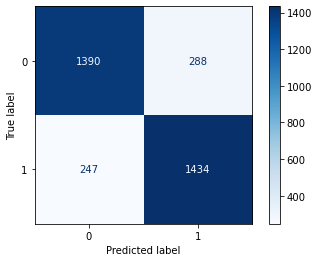

In [107]:
# Model 3 predictions
preds3 = pipe.predict(X_test)

# Model 3 Confusion Matrix Values
tn, fp, fn, tp = confusion_matrix(y_test, preds3).ravel()

# View confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format='d');

These numbers look far more promising, although it's a little odd for the test data to perform better than the training data.  There's definitely no overfit, but there could be some bias.

In [108]:
# Specificity
spec = tn / (tn + fp)
spec

0.8283671036948749

In [109]:
# Precision
prec = tp / (tp + fp)
prec

0.8327526132404182

# Naive Bayes + Grid Search

Grid Search 1:

In [39]:
pipe_params = {
    'cv__max_features': [2000, 3000, 4000, 5000],
    'cv__min_df': [2, 3],
    'cv__max_df': [0.9, 0.95],
    'cv__ngram_range': [(1,1), (1,2)]
}

In [40]:
# Instantiate GridSearchCV.
gs = GridSearchCV(
    # what object are we optimizing?
    estimator = pipe,
    # what parameters values are we searching?
    param_grid = pipe_params,
    # 5-fold cross-validation.
    cv = 5,
    n_jobs = -1
)

In [41]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cv__max_df': [0.9, 0.95],
                         'cv__max_features': [2000, 3000, 4000, 5000],
                         'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 1), (1, 2)]})

In [42]:
gs.best_score_

0.8175411966444557

In [43]:
gs.best_params_

{'cv__max_df': 0.9,
 'cv__max_features': 5000,
 'cv__min_df': 2,
 'cv__ngram_range': (1, 2)}

Grid Search 2:

In [44]:
# Modify params to try to improve scores

pipe_params = {
    'cv__max_features': [4000, 5000, 6000, 7000],
    'cv__min_df': [1, 2, 3],
    'cv__max_df': [0.9, 0.95],
    'cv__ngram_range': [(1,1), (1,2), (1,2,3)]
}

In [45]:
# Instantiate GridSearchCV.
gs2 = GridSearchCV(
    # what object are we optimizing?
    estimator = pipe,
    # what parameters values are we searching?
    param_grid = pipe_params,
    # 5-fold cross-validation.
    cv = 5,
    n_jobs = -1
)

In [46]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cv__max_df': [0.9, 0.95],
                         'cv__max_features': [4000, 5000, 6000, 7000],
                         'cv__min_df': [1, 2, 3],
                         'cv__ngram_range': [(1, 1), (1, 2)]})

In [47]:
gs2.best_score_

0.821794794560042

In [48]:
gs2.best_params_

{'cv__max_df': 0.9,
 'cv__max_features': 7000,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 2)}

Grid Search 3:

In [65]:
# Modify params to try to improve model

pipe_params = {
    'cv__max_features': [7000, 8000, 9000, 10000],
    'cv__min_df': [1, 2],
    'cv__max_df': [0.85, 0.9],
    'cv__ngram_range': [(1,2)]
}

In [66]:
# Instantiate GridSearchCV.
gs3 = GridSearchCV(
    # what object are we optimizing?
    estimator = pipe,
    # what parameters values are we searching?
    param_grid = pipe_params,
    # 5-fold cross-validation.
    cv = 5,
    n_jobs = -1
)

In [67]:
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cv__max_df': [0.85, 0.9],
                         'cv__max_features': [7000, 8000, 9000, 10000],
                         'cv__min_df': [1, 2], 'cv__ngram_range': [(1, 2)]})

In [68]:
gs3.score(X_test, y_test)

0.841024114319738

In [69]:
gs3.best_score_

0.8238475804837957

In [54]:
gs3.best_params_

{'cv__max_df': 0.85,
 'cv__max_features': 9000,
 'cv__min_df': 2,
 'cv__ngram_range': (1, 2)}

I'm going to home in on the number of features.  I'm also going to adjust the max_df.

Grid Search 4:

In [55]:
pipe_params = {
    'cv__max_features': [8500, 9000, 9500],
    'cv__min_df': [1, 2],
    'cv__max_df': [0.75, 0.80, 0.85],
    'cv__ngram_range': [(1,2)]
}

In [56]:
# Instantiate GridSearchCV.
gs4 = GridSearchCV(
    # what object are we optimizing?
    estimator = pipe,
    # what parameters values are we searching?
    param_grid = pipe_params,
    # 5-fold cross-validation.
    cv = 5,
    n_jobs = -1
)

In [57]:
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cv__max_df': [0.75, 0.8, 0.85],
                         'cv__max_features': [8500, 9000, 9500],
                         'cv__min_df': [1, 2], 'cv__ngram_range': [(1, 2)]})

In [58]:
gs4.score(X_test, y_test)

0.8413218219708246

In [59]:
gs4.best_score_

0.8238475804837957

In [60]:
gs4.best_params_

{'cv__max_df': 0.75,
 'cv__max_features': 8500,
 'cv__min_df': 2,
 'cv__ngram_range': (1, 2)}

The best scores for Grid Searches 3 and 4 are identical; the score differs slightly.  The best grid search score is .824.  Since the Gridsearch scores are much closer together, I believe that the Naive Bayes Multinomial model using Gridsearch lassification 4 is the best model.  Model 4 accurately classifies 1 more post than Model 3 does, per the confusion matrices below.

Confusion Matrices: Models 3 and 4

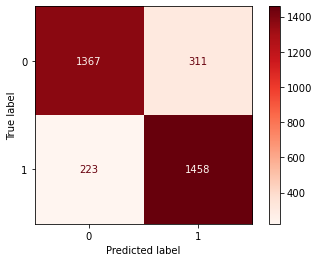

In [82]:
# Model 3 predictions
preds3 = gs3.predict(X_test)

# Model 3 Confusion Matrix Values
tn, fp, fn, tp = confusion_matrix(y_test, preds3).ravel()

# View confusion matrix
plot_confusion_matrix(gs3, X_test, y_test, cmap='Reds', values_format='d');

Model 4 Preds and Confusion Matrix:

In [ ]:
gs4.score(X_test, y_test)

83.4% accuracy is a good score.  However, could it be better?  In other words, could the branding between Disney and Universal be more distinct as to evoke greater differention in reddit posts?  Or is there just too much overlap, since they are both theme parks?

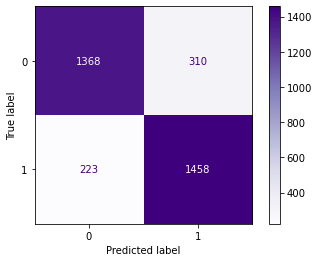

In [71]:
# Model 4 predictions
preds4 = gs4.predict(X_test)

# Model 4 Confusion Matrix Values
tn, fp, fn, tp = confusion_matrix(y_test, preds4).ravel()

# View confusion matrix
plot_confusion_matrix(gs4, X_test, y_test, cmap='Purples', values_format='d');

In [72]:
# Specificity
spec = tn / (tn + fp)
spec

0.8152562574493445

We're most interested in accuracy and precision.  We don't want our branding lost to a competitor.  Ideally, the brands would be distinct, but since Disney and Universal parks are all theme parks, some overlap is inevitable.

In [73]:
# Precision
prec = tp / (tp + fp)
prec

0.8246606334841629

In [80]:
# Accuracy
acc = (tp + tn) / (tp + tn + fp + fn)
acc

0.8413218219708246

This model has a precision score of .82 and 84.1% accuracy.  The accuracy scores are the same whether Grid Search is used or not.  However, both precision and specificity are slightly higher when Grid Search is not used.  Therefore, the multinomial Naive Bayes model without Grid Search earns the title of "Best Model."

Since there is a lot of overlap in what Disney and Universal offer guests, some overlap is inevitable.  Both parks share some of the same language, such as "annual pass," "park," "world" (Disney World, the Wizzarding World of Harry Potter, Jurassic World), some words will not distinguish the two.  Even "magic" can be problematic, since it applies to "Magic Kingdom" and Harry Potter.  Generally, "magic" is Disney's brand.  Park guests are greeted and sent off with the phrase, "Have a magical day."  Universal Studios uses "universal" in branding.  Billboards featuring Harry Potter read, "Courage is Universal."  Other billboards read, "Adventure is Universal" or other, similar phrases evoking bravery.

Overall, the Naive Bayes model predicted the correct subreddit over 88% of the time on the test data and over 80% of the time on the training data.  Aside from the Logistic Regression model and the Null model, all models predicted the subreddit correctly over 80% of the time.  For models based on qualitative data from humans in the wild (i.e. not laboratory-controled and only marginally controled by a moderator), these scores are excellent.

Nine of the top 10 words and phrases were completely different for Disney and Universal after stop words were removed.  The phrase the two subreddits shared was "theme park."  This is actually a good thing, since both brands brand their parks as "theme parks" rather than "amusement parks."

Though it's not in the top 10 on either list, I'll check counts of "magic" in both subreddits.

In [75]:
df.to_csv('df_clean1.csv', index=True)
df2.to_csv('df2_clean2.csv', index=True)

# Conclusions and Recommendations

The low occurance of "magic" in the Disney subreddit surprises me.  This probably should concern Disney Marketing, since magic is Disney's brand.  To maintain their brand, Disney might consider pivoting slightly, to "worlds far away," "imagination," or something similar.  Aside from Frozen, recent Disney movies have not included a lot of magic.  Mulan disguised herself as a boy.  Monsters Inc features monsters working.  Aside from being able to enter children's rooms through their closets, there's no magic involved.  Inside Out, the Good Dinosaur, Finding Nemo, Finding Dory, Zootopia, Coco, and Moana are all coming of age stories.  Even Mary Poppins Returns features magic, but ultimately is a comming of age story.  Aside from toys and cars coming alive, there's no magic in the Toy Story or Cars movies.

Disney recently renamed all of their annual passes (and greatly increased the price on each of them).  Instead of bronze, silver, gold, and platinum passes, there are the pixie dust, pirate, sorcerer, and incredi-pass.  I'm guessing that the last one is promoting The Incredibles.  Renaming the passes to align with the magic theme (or a new pirates exhibit) signals that they're doubling down on their Magic branding.

If Disney chooses to pivot towards a slightly different brand, then I recommend clarifying what that brand is, based on where they are and what new content is in the works.  One possibility is Imagination.  This would tie in well with EPCOT (which desperately needs clear branding) and Disney's Imagineering work group, which is considered the heart of Disney design, according to a Disney+ documentary.  "Dream it" or "Dream it, be it" could also work.

At the heart of the question is how guests and potential guests view "magic."  Is it passe?  Do they think of older films with evil witches and good fairies?  While I doubt evil witches and good fairies will die out completely, they are not highly represented in Disney's newer films.  Perhaps "magical" no longer represents Disney best.  Alternatively, perhaps Disney is seeking to redefine or expand the definition of Magic.  Further research is warranted, but I am not privvy to proprietary data.

If I were a marketing data science cast member at Disney, I would recommend researching other unofficial Disney reddits and social media pages to examine the most frequently discussed topics and posted images.  Then I'd perform a meta-analysis on all that information to get an updated view of the Disney landscape in recent past, current, and potential customers' eyes.  What strikes them about Disney?  What draws them to Disney?  What buzzwords do they repeat most that are uniquely Disney?  Then I would compare these words and themes with words and themes on Universal reddits and other social media pages to ensure that Disney's brand is unique.